## Example uses of the EarthServer 2 data access library

<p>This notebok gives a quick overview of teh current state of the data access library. The purpose of the library is to reduce the barrier for third parties to create data clients on top of the data services created as part of the project.</p>
<p>The library can be downloaded from github - final location to be decided - @ <a href="https://github.com/doclements/cci_data_lib">https://github.com/doclements/cci_data_lib</a>
<p>The Library currently allows 4 types of data access</p>

 * Point
 * Point Timeseries
 * Area
 * Area Timeseries

## Imports and Initialising 

In [1]:
from cci_data_service.query.point import Point
from cci_data_service.query.point_timeseries import PointTimeSeries
from cci_data_service.query.area import Area
from cci_data_service.query.area_timeseries import AreaTimeseries
from cci_data_service.service import Service

from cci_data_service.query.query import Query

import matplotlib.pyplot as plt
import numpy as np
import matplotlib



In [2]:
service = Service("http://earthserver.pml.ac.uk/rasdaman/ows")


In [11]:
# just dump the available coverage names to test Service was initialised correctly
print service.coverages.keys()

[u'CCI_V2_monthly_chlor_a_rmsd', u'V3_daily_cci_2015_insitu_match_test', u'OCCCI_V3_daily_chlor_a_bias', u'CCI_V2_monthly_Rrs_490', u'OCCCI_V3_monthly_rrs_443_rmsd', u'attempt_vlad_avg_new', u'CCI_V2_monthly_Rrs_670', u'OCCCI_V3_monthly_rrs_670_rmsd', u'OCCCI_V3_monthly_rrs_510_bias', u'OCCCI_V3_monthly_rrs_670_bias', u'CCI_V2_monthly_Rrs_510', u'OCCCI_V3_monthly_rrs_443_bias', u'OCCCI_V3_monthly_rrs_490', u'CCI_V2_monthly_Rrs_412', u'OCCCI_V3_daily_chlor_a_rmsd3', u'attempt_vlad_single', u'CCI_V2_monthly_Rrs_443', u'CCI_V2_monthly_rrs_490', u'V2_monthly_cci_uncert_combined_test', u'V2_monthly_CCI_chlor_a_insitu_test', u'CCI_V2_monthly_rrs_670', u'V2_daily_CCI_chlor_a_insitu_test', u'OCCCI_V3_daily_chlor_a', u'OCCCI_V3_monthly_rrs_510_rmsd', u'CCI_V2_monthly_rrs_510', u'OCCCI_V3_daily_chlor_a_rmsd', u'OCCCI_V3_monthly_rrs_490_rmsd', u'V1_monthly_CCI_chlor_a_insitu_test', u'arsf_test_2_lv1', u'CCI_V2_monthly_rrs_412', u'CCI_V2_monthly_Rrs_555', u'V3_daily_cci_monthly_insitu', u'OCCCI_V3

## Point Extraction

In [12]:
point = Point(service,55, -40, "2006-06-01T00:00:00Z", service.coverages['OCCCI_V3_monthly_chlor_a'])

print point.data



for c in (OCCCI_V3_monthly_chlor_a)
return
encode (
   c[Lat(55), Long(-40), ansi("2006-06-01T00:00:00Z")], "csv"
)

0.653626


## Point Time Series Extraction

In [18]:
pointTS = PointTimeSeries(service,55, -40, "2006-06-01T00:00:00Z","2006-11-01T00:00:00Z", service.coverages['OCCCI_V3_monthly_chlor_a'])
print pointTS.data

[ 0.653626  0.763921  0.782743  0.84124   0.356365  0.372779]


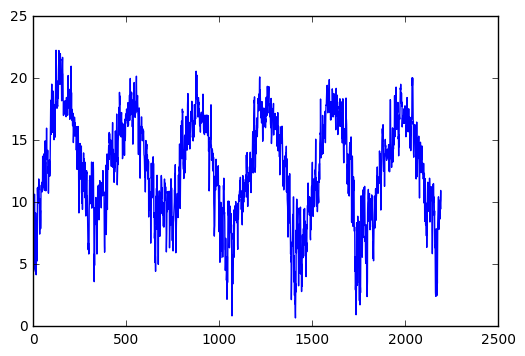

In [21]:
# ECMWF time series test
# init ecmwf Service 
ecmwf_service = Service("http://earthserver.ecmwf.int/rasdaman/ows")

%matplotlib inline

point = PointTimeSeries(ecmwf_service,50.347472, -4.217737,  "2006-03-01T12:00:00Z", "2012-03-01T12:00:00Z", ecmwf_service.coverages['temp2m'])
plt.plot([x - 273.15 for x in point.data][0::4])
plt.show()

## Area Extraction
<p>Slightly more complicated than the Point extraction as there is now a format choice. By default the library will use "csv" as teh format and then parse the resulting text into a numpy array. This can be slow if your dealing with a huge/high resolution image such as the LandSat 8 images of MEEO. In those instances it is probably best to change the format to one of teh other allowed options, currently hard coded as "netcdf2 or "gtiff".</p>

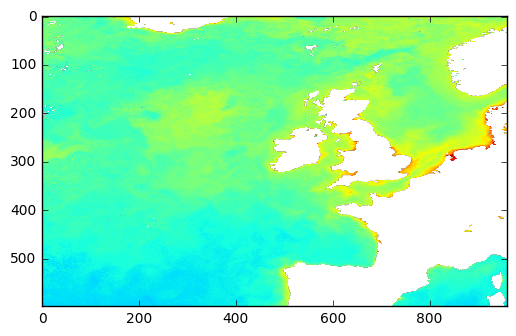

In [25]:
# csv output will be auto parsed into a numpy array this example then snows potting that using matplot lib
# need a clean way to remove nulls
area = Area(service, 40, 65, -30, 10, "2006-09-01T00:00:00Z",service.coverages['OCCCI_V3_monthly_chlor_a'], output="csv")
area.data[area.data == 9.96921e+36] = None
plt.imshow(area.data, norm=matplotlib.colors.LogNorm())
plt.show()

## Area Time Series Extraction
<p>This class allows for the generation of either 3d raster files or as with teh single slice extraction a numpy array. The data will be parsed into a 3d array for use with your own processing code, or matplot lib again.</p>

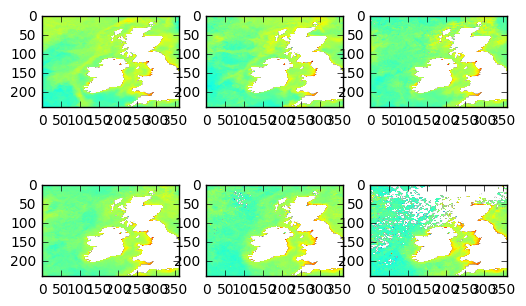

In [26]:
# csv output will be auto parsed into a numpy array this example then snows potting that using matplot lib
# need a clean way to remove nulls
areaTS = AreaTimeseries(service, 50, 60, -15, 0, "2006-06-01T00:00:00Z","2006-11-01T00:00:00Z",service.coverages['OCCCI_V3_monthly_chlor_a'], output="csv")
areaTS.data[areaTS.data == 9.96921e+36] = None
_min =  np.nanmin(areaTS.data)
_max =  np.nanmax(areaTS.data)
st_val = 231
plt.figure(1)
for x in range(areaTS.data.shape[0]):
   temp = st_val + x
   f = plt.subplot(temp)
   f.imshow(areaTS.data[x],norm=matplotlib.colors.LogNorm(vmin=_min, vmax=_max) )
plt.show()

## Custom Query example
<p> This shows the way in which teh library can be extended with custom classes to represent more complex queries. In this case we take a landsat 8 image id, but not the band info, we then select teh correct bands internally to generate an RGB image.</p>

In [29]:
from cci_data_service.query.templates import landsat_rgb_area
from cci_data_service.utils import create_query, web_post, web_post_file

class CustomQuery(Query):
    def __init__(self, service, south, north, west, east, date, coverage_id, output="csv"):
        coverage = service.coverages['L8_B5_'+coverage_id]
        super(CustomQuery, self).__init__(service, coverage)
        self.template_params = {
            "swath_id": coverage_id,
            "south": south,
            "north": north,
            "west": west,
            "east": east,
            "date": date,
            "time_label":self.coverage_time,
            "x_label":self.x_name,
            "y_label":self.y_name
        }
        self.output = output
        self.template = landsat_rgb_area
        self._get_data()

    def _get_data(self):
        self.query = create_query(self)
        print self.query
        if self.output == "csv":
            self.data = web_post(self.wcps_url, {"query":self.query})[1:-1]
            self.data = self.data.split('},{')
            self.data = [x.split(',') for x in self.data]
            self.data = np.array(self.data)
            self.data = self.data.astype(np.float)
        if self.output == "netcdf":
            self.data = web_post_file(self.wcps_url, {"query":self.query})
        if self.output == "gtiff":
            self.data = web_post_file(self.wcps_url, {"query":self.query})
        if self.output == "png":
            pass





In [31]:
meeo_service = Service("http://eodataservice.org/rasdaman/ows")


meeo_area = CustomQuery(meeo_service, 4902991, 4917275, 377983, 390000, "2015-05-31T10:34:57Z" , "32631_30")
print meeo_area.data.shape
print meeo_area.data
print np.min(meeo_area.data)
print np.max(meeo_area.data)
plt.imshow(meeo_area.data)
plt.show()


for r in (L8_B6_32631_30), g in (L8_B5_32631_30), b in (L8_B4_32631_30)
return 
encode ( {
red:   ( (r * 0.00002) - 0.1 ) * 255;
green: ( (g * 0.00002) - 0.1 ) * 255;
blue:  ( (b * 0.00002) - 0.1 ) * 255
}
[N(4902991:4917275), E(377983:390000), unix("2015-05-31T10:34:57Z")]
,"png")



ValueError: could not convert string to float: html><head><title>Web Coverage Processing Service</title></head><body> <h1>An error has occured</h1> <p>Petascope Error: Error evaluating rasdaman query: 'SELECT encode({ (  ( r * 0.00002 )  - 0.1 )  